# Libraries

In [1]:
!pip install opencv-python mediapipe numpy pandas scikit-learn joblib tqdm matplotlib seaborn

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.8 kB 1.4 MB/s eta 0:00:01
     -------------------- ------------------- 30.7/60.8 kB 1.4 MB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 463.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/51.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/51.0 MB 1.9 MB/s eta 0:00:27
   ---------------------------------------- 0.0/51.0 MB 1.9 MB/s eta 0:00:27
   ---------------------------------------- 0.1/51.0 MB 653.6 kB/s eta 0:01:18
   ---------------------------------------- 0.2/51.0 MB 1.3 MB/s eta 0:00:39
   ---------------------------------------- 0.2/51.0 MB 1.3 MB/s eta 0:00:39
   ---------------------------------------- 0.2/51.0 MB 1.1 MB/s eta 0:00:48
   ---------------------------------------- 0.4/51.0 MB 1.7 MB/s eta 0:00:

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.


In [2]:
# Import libraries for video processing, pose estimation, ML, and visualization
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize MediaPipe Pose and Drawing utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Define dataset paths and constants
DATASET_DIR = "dataset_small"
SUBFOLDERS = ["train", "val", "test"]
CLASSES = ["Arm Raise Correct", "Arm Raise Incorrect"]
LABEL_MAP = {"Arm Raise Correct": 1, "Arm Raise Incorrect": 0}

print("Libraries imported and MediaPipe initialized.")

Libraries imported and MediaPipe initialized.


# Helper Functions

In [7]:
# Function to extract landmarks from a frame
def extract_landmarks(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        # Extract x, y, z, visibility for all 33 keypoints
        features = []
        for lm in landmarks:
            features.extend([lm.x, lm.y, lm.z, lm.visibility])
        return np.array(features), results.pose_landmarks
    return None, None

# Function to compute joint angles (e.g., elbow angle)
def compute_angle(p1, p2, p3):
    # p1, p2, p3 are landmark coordinates (x, y, z)
    a = np.array([p1.x, p1.y, p1.z])
    b = np.array([p2.x, p2.y, p2.z])
    c = np.array([p3.x, p3.y, p3.z])
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# Function to compute distance between two points
def compute_distance(p1, p2):
    return np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2 + (p1.z - p2.z)**2)

# Function to normalize landmarks relative to torso and scale
def normalize_landmarks(features, landmarks):
    # Normalize by subtracting torso midpoint (average of shoulders)
    shoulder_left = landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    shoulder_right = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    torso_x = (shoulder_left.x + shoulder_right.x) / 2
    torso_y = (shoulder_left.y + shoulder_right.y) / 2
    # Compute shoulder width as scaling factor
    shoulder_width = compute_distance(shoulder_left, shoulder_right)
    features_normalized = []
    for i in range(0, len(features), 4):
        features_normalized.extend([
            (features[i] - torso_x) / shoulder_width,  # x
            (features[i + 1] - torso_y) / shoulder_width,  # y
            features[i + 2] / shoulder_width,  # z
            features[i + 3]  # visibility
        ])
    return np.array(features_normalized)

# Function to extract features (landmarks + angles + distances) from a frame
def extract_features(frame):
    landmarks_array, landmarks = extract_landmarks(frame)
    if landmarks_array is None:
        return None
    # Normalize landmarks
    features = normalize_landmarks(landmarks_array, landmarks)
    # Compute additional features: elbow angles and shoulder-to-wrist distances
    left_elbow_angle = compute_angle(
        landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER],
        landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW],
        landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]
    )
    right_elbow_angle = compute_angle(
        landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER],
        landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW],
        landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
    )
    left_shoulder_wrist_dist = compute_distance(
        landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER],
        landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]
    ) / compute_distance(landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER], landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER])
    right_shoulder_wrist_dist = compute_distance(
        landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER],
        landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
    ) / compute_distance(landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER], landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER])
    # Combine features
    features = np.append(features, [left_elbow_angle, right_elbow_angle, left_shoulder_wrist_dist, right_shoulder_wrist_dist])
    return features

# Function to process a video and extract averaged features
def process_video(video_path, frame_skip=5):
    cap = cv2.VideoCapture(video_path)
    features_list = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_skip == 0:
            features = extract_features(frame)
            if features is not None:
                features_list.append(features)
        frame_count += 1
    cap.release()
    if features_list:
        return np.mean(features_list, axis=0)  # Average features across frames
    return None

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Incorrect', 'Correct'], yticklabels=['Incorrect', 'Correct'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print("Helper functions defined.")

Helper functions defined.


# Preprocess Dataset

In [8]:
# Function to preprocess dataset for a given frame skip
def preprocess_dataset(frame_skip):
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []
    
    for split in SUBFOLDERS:
        for class_name in CLASSES:
            folder_path = os.path.join(DATASET_DIR, split, class_name)
            videos = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mp4")]
            label = LABEL_MAP[class_name]
            for video in tqdm(videos, desc=f"Processing {split}/{class_name}"):
                features = process_video(video, frame_skip=frame_skip)
                if features is not None:
                    if split == "train":
                        X_train.append(features)
                        y_train.append(label)
                    elif split == "val":
                        X_val.append(features)
                        y_val.append(label)
                    else:  # test
                        X_test.append(features)
                        y_test.append(label)
    
    return (np.array(X_train), np.array(y_train),
            np.array(X_val), np.array(y_val),
            np.array(X_test), np.array(y_test))

# Test different frame skip rates
frame_skips = [1, 3, 5, 10]
val_accuracies = []
best_frame_skip = 5  # Default
best_val_accuracy = 0
best_data = None

for frame_skip in frame_skips:
    print(f"\nTesting frame skip: {frame_skip}")
    data = preprocess_dataset(frame_skip)
    X_train, y_train, X_val, y_val, X_test, y_test = data
    # Train a quick model to evaluate
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_frame_skip = frame_skip
        best_data = data

# Select best frame skip
X_train, y_train, X_val, y_val, X_test, y_test = best_data
print(f"\nSelected frame skip: {best_frame_skip} with validation accuracy: {best_val_accuracy:.4f}")
print(f"Data shapes: X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# Save preprocessed data
np.savez("preprocessed_data.npz", X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test)


Testing frame skip: 1


Processing train/Arm Raise Correct:   0%|          | 0/12 [00:00<?, ?it/s]

Processing test/Arm Raise Incorrect: 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]


Validation Accuracy: 0.7500

Testing frame skip: 3


Processing test/Arm Raise Incorrect: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Validation Accuracy: 0.6250

Testing frame skip: 5


Processing test/Arm Raise Incorrect: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Validation Accuracy: 0.5000

Testing frame skip: 10


Processing test/Arm Raise Incorrect: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

Validation Accuracy: 0.6250

Selected frame skip: 1 with validation accuracy: 0.7500
Data shapes: X_train: (24, 136), X_val: (8, 136), X_test: (8, 136)


# Training Random Forest Model

In [9]:
# Test feature sets: raw landmarks, normalized landmarks, full features
feature_sets = {
    "raw": X_train[:, :132],  # Only landmarks
    "normalized": X_train,  # Normalized landmarks + angles + distances
}
best_model = None
best_features = None
best_val_accuracy = 0

for name, X_train_subset in feature_sets.items():
    print(f"\nTraining with {name} features")
    # Prepare corresponding validation set
    if name == "raw":
        X_val_subset = X_val[:, :132]
    else:
        X_val_subset = X_val
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None]
    }
    model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train_subset, y_train)
    # Evaluate on validation set
    y_val_pred = grid_search.predict(X_val_subset)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy with {name} features: {val_accuracy:.4f}")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = grid_search.best_estimator_
        best_features = name
        best_X_train = X_train_subset
        best_X_val = X_val_subset
        best_X_test = X_test[:, :132] if name == "raw" else X_test

print(f"\nBest model uses {best_features} features with validation accuracy: {best_val_accuracy:.4f}")
print(f"Best parameters: {best_model.get_params()}")

# Save best model
joblib.dump(best_model, "postureguardian_model.joblib")


Training with raw features
Validation Accuracy with raw features: 0.7500

Training with normalized features
Validation Accuracy with normalized features: 0.7500

Best model uses raw features with validation accuracy: 0.7500
Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


['postureguardian_model.joblib']

# Evaluate Model

Test Set Evaluation:
Accuracy: 0.8750
Precision: 1.0000
Recall: 0.7500
F1-Score: 0.8571

Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.80      1.00      0.89         4
     Correct       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



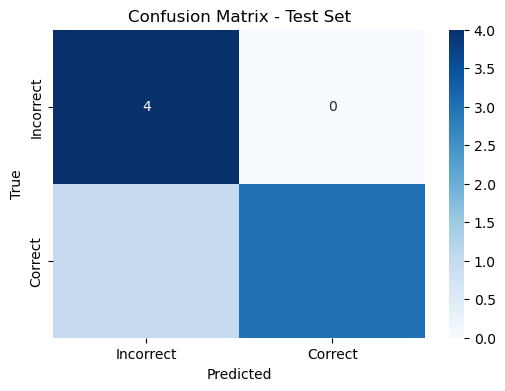

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


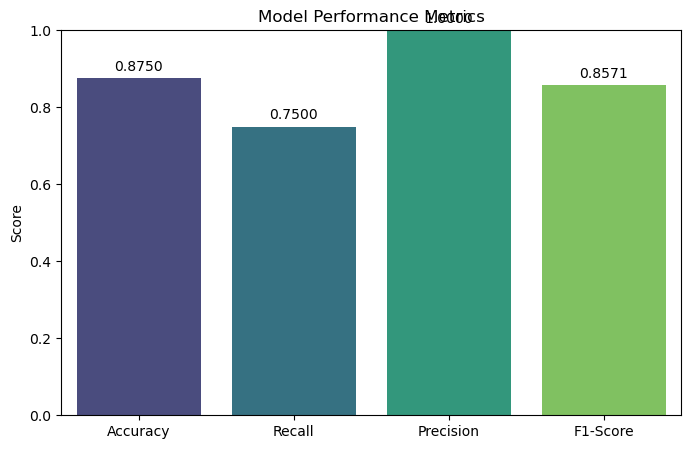

In [10]:
# Evaluate model on test set
y_test_pred = best_model.predict(best_X_test)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("Test Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Incorrect', 'Correct']))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Incorrect', 'Correct'], yticklabels=['Incorrect', 'Correct'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot precision, recall, F1-score
metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
values = [accuracy, recall, precision, f1]
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.show()

# Real-Time Inference

In [11]:
# Function to draw arm-focused skeleton
def draw_arm_skeleton(frame, landmarks):
    arm_connections = [
        (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW),
        (mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST),
        (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW),
        (mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST)
    ]
    for connection in arm_connections:
        start = landmarks.landmark[connection[0]]
        end = landmarks.landmark[connection[1]]
        cv2.line(frame, 
                 (int(start.x * frame.shape[1]), int(start.y * frame.shape[0])),
                 (int(end.x * frame.shape[1]), int(end.y * frame.shape[0])),
                 (255, 255, 255), 2)
        cv2.circle(frame, 
                   (int(start.x * frame.shape[1]), int(start.y * frame.shape[0])), 
                   5, (255, 0, 0), -1)
        cv2.circle(frame, 
                   (int(end.x * frame.shape[1]), int(end.y * frame.shape[0])), 
                   5, (255, 0, 0), -1)

# Real-time inference
def real_time_inference(model, feature_type='normalized', window_size=10):
    cap = cv2.VideoCapture(0)
    predictions = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Extract features
        features = extract_features(frame)
        if features is not None:
            # Select features based on best model
            if feature_type == 'raw':
                features = features[:132]
            # Predict
            prediction = model.predict([features])[0]
            predictions.append(prediction)
            # Average predictions over window
            if len(predictions) > window_size:
                predictions.pop(0)
            avg_prediction = np.mean(predictions) > 0.5
            label = "Correct" if avg_prediction else "Incorrect"
            color = (0, 255, 0) if avg_prediction else (0, 0, 255)
            # Display label
            cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            # Draw arm skeleton
            _, landmarks = extract_landmarks(frame)
            if landmarks:
                draw_arm_skeleton(frame, landmarks)
        cv2.imshow("PostureGuardian", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Run real-time inference
print("Starting real-time inference (press 'q' to quit)...")
real_time_inference(best_model, feature_type=best_features)

Starting real-time inference (press 'q' to quit)...
